# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

There are a great number of cars in the dataset with different features. This features affect directly the price
of a car, those could increase or decrease the price.

The goal is to determine what are the features that increase the price of the car to maximise profit, for instance having a 4df, red, 2020 could have a better price that a car fwd, whit, 2020.

We can get to the point is the weight for each feature in the car price.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**Data**
-The dataset has 426K cars and most of the features are categorical
- There are many null values in those categorical features
- The categories are not binary
- There are duplicate cars
- There are outliers prices

In [1407]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(display="diagram")

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [1408]:
cars = pd.read_csv('data/vehicles.csv')

In [1409]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

<Axes: >

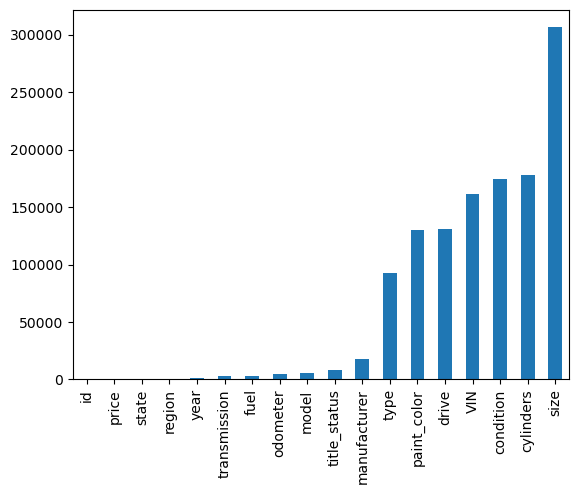

In [1410]:
cars.isnull().sum().sort_values().plot(kind = 'bar')

**Since most of the features are categorical - checking the unique values, thinking on the encode needed**

In [1596]:
cars.condition.unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [1605]:
cars.cylinders.unique()

array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
       'other', '3 cylinders', '10 cylinders', '12 cylinders'],
      dtype=object)

In [1606]:
cars.fuel.unique()

array([nan, 'gas', 'other', 'diesel', 'hybrid', 'electric'], dtype=object)

In [1607]:
cars.transmission.unique()

array([nan, 'other', 'automatic', 'manual'], dtype=object)

**Confirming there are records with out any of the features of interest**

In [1602]:
cars[cars['year'].isnull() & cars['manufacturer'].isnull() & cars['model'].isnull() & cars['condition'].isnull() & cars['cylinders'].isnull() & \
cars['fuel'].isnull() & cars['transmission'].isnull() & cars['odometer'].isnull() & cars['drive'].isnull() \
& cars['size'].isnull() & cars['type'].isnull() & cars['paint_color'].isnull()].sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
118854,7313585697,tampa bay area,3700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
197407,7315202002,detroit metro,9950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mi
5,7222379453,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
16,7222753076,bellingham,24999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wa
70037,7271652768,visalia-tulare,2900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca


**Cheking for price outliers**

In [1611]:
cars[cars['price'] > 500000].sample(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
318592,7308056031,eugene,3736928711,2007.0,toyota,tundra,excellent,8 cylinders,gas,164000.0,clean,automatic,NaN,4wd,full-size,pickup,silver,or
26075,7314964461,fresno / madera,1111111,2014.0,chevrolet,NaN,NaN,NaN,other,11.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ca
232829,7313752706,charlotte,1000000,2016.0,ford,f150,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,nc


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

**Observations**
1. Remove rows where manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, drive, size, type, and paint_color and nan
2. VIN Number has duplicates (this number suppose to be unique) and many of them are null. 
This information is not useful for the model. Deleting column.
3. Cylinders for electric cars do no apply. As of March 2024, 43.4% of cars on the road in the United States have 4-cylinder engines. However, this dataset has the most frequent cylinders  as 6, so nan will be fill with 6
4. Opten for some key features such as color to fill the most frequent value
5. Leave the drive with the nan in case became a key feature I will review this again
6. Remove duplicates
7. Removing outliners there some cases price close to a billion such as 99999999 and 987654321 for a 1960 ford

In [1504]:
cars.shape

(426880, 18)

In [1505]:
#Removing the cars with all these categories null
features_to_clean = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive' \
                    , 'size', 'type', 'paint_color']
cars_clean = cars.dropna(subset = features_to_clean, how = 'all')

In [1506]:
# Dropping VIN number and id
cars_clean = cars_clean.drop(['VIN', 'id'], axis = 1)

In [1507]:
#Taking the most frequent cylinders to fillna in this case is 6
most_frequent_cylinders = cars_clean['cylinders'].mode()[0]
cars_clean['cylinders'].fillna(most_frequent_cylinders, inplace=True)

In [1508]:
most_frequent_paint_color = cars_clean['paint_color'].mode()[0]
cars_clean['paint_color'].fillna(most_frequent_paint_color, inplace=True)

In [1509]:
most_frequent_size = cars_clean['size'].mode()[0]
cars_clean['size'].fillna(most_frequent_size, inplace=True)

In [1510]:
most_frequent_type = cars_clean['type'].mode()[0]
cars_clean['type'].fillna(most_frequent_type, inplace=True)

In [1511]:
most_frequent_condition = cars_clean['condition'].mode()[0]
cars_clean['condition'].fillna(most_frequent_condition, inplace=True)

In [1512]:
most_frequent_drive = cars_clean['drive'].mode()[0]
cars_clean['drive'].fillna(most_frequent_drive, inplace=True)

Dropna for the features with few null values

In [1513]:
cars_clean = cars_clean.dropna(subset = ['manufacturer'])

In [1514]:
cars_clean = cars_clean.dropna(subset = ['title_status'])

In [1515]:
cars_clean = cars_clean.dropna(subset = ['model'])

In [1516]:
cars_clean = cars_clean.dropna(subset = ['odometer'])

In [1517]:
cars_clean = cars_clean.dropna(subset = ['transmission'])

In [1518]:
cars_clean = cars_clean.dropna(subset = ['fuel'])

In [1519]:
cars_clean = cars_clean.dropna(subset = ['year'])

In [1520]:
cars_clean.shape

(389604, 16)

In [1521]:
#Checking for duplicates
cars_dups = cars_clean[cars_clean.duplicated()]
cars_dups.head(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
422,birmingham,3399,2006.0,buick,lacrosse,good,6 cylinders,gas,160218.0,clean,automatic,fwd,full-size,sedan,blue,al
425,birmingham,3900,2009.0,hyundai,elantra,good,4 cylinders,gas,162005.0,clean,automatic,rwd,full-size,sedan,white,al
429,birmingham,3300,1999.0,chrysler,300m,good,6 cylinders,gas,162026.0,clean,automatic,fwd,full-size,sedan,white,al
454,birmingham,1300,1969.0,mercedes-benz,benz,good,6 cylinders,gas,12774.0,clean,automatic,4wd,full-size,sedan,white,al
456,birmingham,3999,2003.0,infiniti,g35 sedan,good,6 cylinders,gas,233830.0,clean,automatic,rwd,full-size,sedan,white,al


In [1522]:
#Remove duplicates
cars_clean = cars_clean.drop_duplicates(keep='last')

In [1523]:
# Filter Outliers
#
# Determining quartiles
first_quartile = ' '
third_quartile = ' '
first_quartile = cars_clean['price']. quantile(.25)
third_quartile = cars_clean['price']. quantile(.75)
print(first_quartile, third_quartile)

6000.0 26990.0


In [1524]:
#Interquartile Range - IQR = Q3 - Q1
iqr = ' ' 
iqr = third_quartile - first_quartile
print(iqr)

20990.0


In [1525]:
# Rule for Outliers - any values greater than the third quartile plus 1.5 x IQR or any values 
# that are less than the first quartile by 1.5 x IQ R are considered outliers
lower = ''
upper = 1
lower = first_quartile - (1.5*iqr)
upper = third_quartile + (1.5*iqr)
print(lower, upper)

-25485.0 58475.0


In [1526]:
# Dropping Outliers
cars_no_outliers = ' ' 
cars_no_outliers = cars_clean.loc [(cars_clean[ 'price'] > lower) & (cars_clean['price'] < upper)]

In [1527]:
cars_no_outliers.shape

(333445, 16)

**TESTING SIZE**

**First pass** is done with the full size after cleaning the data that is 333445 cars with 16 columns

**Second pass** is done with 1350 cars due to memory issues running OneHotEncoder

In [1528]:
car_sales = cars_no_outliers.copy()

In [1529]:
car_details = cars_no_outliers.sample(1350).copy()

In [1530]:
car_details.shape

(1350, 16)

In [1531]:
car_sales.shape

(333445, 16)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

The goal of the project is to identify what car features increases the price of used cards. Because of this 
I worked with 3 model:
1. Ridge
2. SequentialFeatureSelector with Lasso
3. RFE with Lasso

Used 2 types of encoding:
1. LabelEncoder for the whole data set (after cleaning)
2. OneHotEncoder for key features

So I repeated the 3 model for each type of encoding. In the first pass I was able to get the most important features. In the second pass the models gave details of what are most prevalent in a great detail.

In [1532]:
categorical_features = cars_no_outliers.select_dtypes('object').columns.tolist()
categorical_features

['region',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [1533]:
#Using LabelEncoder for categorical features
encoders = {}

# Factorize each column
for column in categorical_features:
    le = LabelEncoder()
    car_sales[column + '_Label'] = le.fit_transform(car_sales[column])
    encoders[column] = le

print("DataFrame with Factorized Columns:")
cars_no_outliers.info()
encoders

DataFrame with Factorized Columns:
<class 'pandas.core.frame.DataFrame'>
Index: 333445 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        333445 non-null  object 
 1   price         333445 non-null  int64  
 2   year          333445 non-null  float64
 3   manufacturer  333445 non-null  object 
 4   model         333445 non-null  object 
 5   condition     333445 non-null  object 
 6   cylinders     333445 non-null  object 
 7   fuel          333445 non-null  object 
 8   odometer      333445 non-null  float64
 9   title_status  333445 non-null  object 
 10  transmission  333445 non-null  object 
 11  drive         333445 non-null  object 
 12  size          333445 non-null  object 
 13  type          333445 non-null  object 
 14  paint_color   333445 non-null  object 
 15  state         333445 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 43.2+ MB


{'region': LabelEncoder(),
 'manufacturer': LabelEncoder(),
 'model': LabelEncoder(),
 'condition': LabelEncoder(),
 'cylinders': LabelEncoder(),
 'fuel': LabelEncoder(),
 'title_status': LabelEncoder(),
 'transmission': LabelEncoder(),
 'drive': LabelEncoder(),
 'size': LabelEncoder(),
 'type': LabelEncoder(),
 'paint_color': LabelEncoder(),
 'state': LabelEncoder()}

In [1534]:
#Dropping all object columns. Create a new dataframe df_numeric
car_sales = car_sales.drop(categorical_features, axis = 1)

In [1535]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333445 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               333445 non-null  int64  
 1   year                333445 non-null  float64
 2   odometer            333445 non-null  float64
 3   region_Label        333445 non-null  int64  
 4   manufacturer_Label  333445 non-null  int64  
 5   model_Label         333445 non-null  int64  
 6   condition_Label     333445 non-null  int64  
 7   cylinders_Label     333445 non-null  int64  
 8   fuel_Label          333445 non-null  int64  
 9   title_status_Label  333445 non-null  int64  
 10  transmission_Label  333445 non-null  int64  
 11  drive_Label         333445 non-null  int64  
 12  size_Label          333445 non-null  int64  
 13  type_Label          333445 non-null  int64  
 14  paint_color_Label   333445 non-null  int64  
 15  state_Label         333445 non-null  i

Now with the numerical features running the correlation heatmap

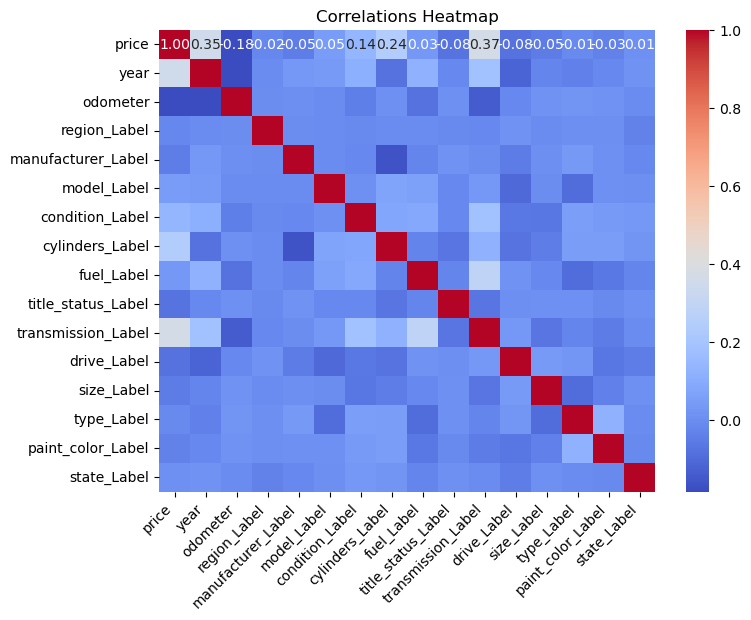

<Figure size 640x480 with 0 Axes>

In [1536]:
plt.figure(figsize=(8, 6))  # Set the figure size (optional)
sns.heatmap(car_sales.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlations Heatmap')  # Add a title (optional)
plt.xticks(rotation=45, ha='right')
plt.show()
plt.savefig('8-1-Heatmap')

Headmap shows a higher relatioship of transmission, cylinders, and year with price, expecting to see these 
features in the feature selection

In [1537]:
X = car_sales.drop('price', axis = 1)
y = car_sales['price']

In [1538]:
# Simple cross validation
X_train, X_test, y_train, y_test = '', '', '', ''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**First model LinearRegression - This will be the base model**

In [1564]:
#Linear Regression Model
#Variables
linreg = ''
coefslr = ''
coefslr_df = '' 
# Fitting the model
linreg = LinearRegression().fit(X_train, y_train)
train_preds = linreg.predict(X_train)
test_preds = linreg.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
coefslr = linreg.coef_
linreg.feature_names_in_

#Printing MSEs
print(f"Mean Train Squared Error: {train_mse: .2f}")
print(f"Mean Test Squared Error: {test_mse: .2f}")
# Getting Coefs
coefslr_df = pd.DataFrame(coefs.T, columns = ["Coefficients"], index = linreg.feature_names_in_)
coefslr_df

Mean Train Squared Error:  122648215.28
Mean Test Squared Error:  123679777.17


,Coefficients
year,3900.310559
odometer,-1273.362066
region_Label,-169.095935
manufacturer_Label,-319.487350
model_Label,134.643701
condition_Label,491.602881
cylinders_Label,2768.488272
fuel_Label,-1228.122920
title_status_Label,-500.903945
transmission_Label,3767.559215


**Ridge model - Getting all Coefficients**

- Bilding a pipe for Ridge using StandardScaler

In [1565]:
#Pipeline for Ridge
pipe = Pipeline([('scale', StandardScaler(with_mean=False)),
                 ('ridge', Ridge())])
param_dict = {'ridge__alpha': np.linspace(1, 100, 100)}

In [1544]:
#Ridge model
#Variables
grid_2 = ''
model_2_train_mse = ''
model_2_test_mse = ''
model_2_best_alpha = ''

grid_2 = GridSearchCV(pipe, param_grid=param_dict)
#Fitting the model
grid_2.fit(X_train, y_train)
train_preds = grid_2.predict(X_train)
test_preds = grid_2.predict(X_test)
#Calculating MSEs
model_2_train_mse = mean_squared_error(y_train, train_preds)
model_2_test_mse = mean_squared_error(y_test, test_preds)
#Getting best params
model_2_best_alpha = grid_2.best_params_

cv_results = grid_2.cv_results_
mean_test_scores = cv_results['mean_test_score']
best_model = grid_2.best_estimator_.named_steps['ridge']
# Getting coefs
coefs = best_model.coef_
# Feature names
feature_names = X.columns

#Printing MSEs
print(f'Train MSE: {model_2_train_mse: .2f}')
print(f'Test MSE: {model_2_test_mse: .2f}')
# Print the best parameters and best score
print("Best Parameters:", grid_2.best_params_)
print("Best Score", grid_2.best_score_)  # Convert from negative MSE
# Putting together coefs and feature names
coefs_df = pd.DataFrame(coefs.T, columns = ["Coefficients"], index = feature_names)
coefs_df

Train MSE: 122648220.30352062
Test MSE: 123679712.83272709
Best Parameters: {'ridge__alpha': 84.0}
Best Cross-Validation MSE: -0.2890247910044848


,Coefficients
year,3900.310559
odometer,-1273.362066
region_Label,-169.095935
manufacturer_Label,-319.487350
model_Label,134.643701
condition_Label,491.602881
cylinders_Label,2768.488272
fuel_Label,-1228.122920
title_status_Label,-500.903945
transmission_Label,3767.559215


**Plotting the Coefficients**

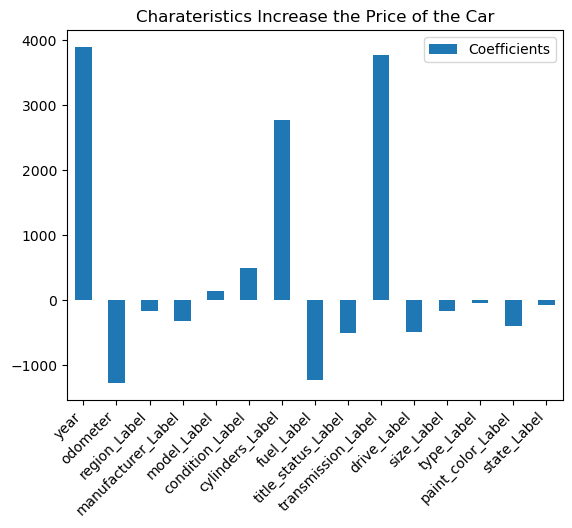

In [1545]:
#Using a bar plot to show the coefs. Added inclination of 45 degrees for the feature labels
coefs_df.plot(kind = 'bar')
plt.title('Charateristics Increase the Price of the Car') 
plt.xticks(rotation=45, ha='right')
plt.show()

**SequentialFeatureSelector with LASSO as estimator and RIDGE as regression**

In [1467]:
#Variables initialization
sequential_train_mse = ''
sequential_test_mse = ''
features = ''
sequential_pipe = ''
#param_dict = {'selector__n_features_to_select': [2, 3, 4, 5, 6, 7, 8]}
sequential_pipe = Pipeline([('selector', SequentialFeatureSelector(estimator = Lasso(), n_features_to_select=6)),
                          ('ridge', Ridge(84))])
#Fitting the model
sequential_pipe.fit(X_train, y_train)
sequential_train_mse = mean_squared_error(y_train, sequential_pipe.predict(X_train))
sequential_test_mse = mean_squared_error(y_test, sequential_pipe.predict(X_test))

#Initializing variables
best_estimator = ''
best_selector = ''
best_model = ''
feature_names = ''
coefs = ''

#Getting column names and compared with process names
best_selector = sequential_pipe.named_steps['selector']
feature_names = X_train.columns[best_selector.get_support()]
features = best_selector.get_feature_names_out()

#Getting coefs ans score
coefs = sequential_pipe.named_steps['ridge'].coef_
score = sequential_pipe.named_steps['ridge'].score
#Printing MSEs results
print(f'Train MSE: {sequential_train_mse: .2f}')
print(f'Test MSE: {sequential_test_mse: .2f}')
#Formatting the coefs
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Train MSE: 123435555.77211216
Test MSE: 124505552.1697575
Score: <bound method RegressorMixin.score of Ridge(alpha=84)>
Coefs: [ 4.54402229e+02 -6.92563909e-03  2.92766503e+03 -1.58664038e+03
 -6.73535061e+02  4.98774221e+03]
Features:  Index(['year', 'odometer', 'cylinders_Label', 'fuel_Label',
       'title_status_Label', 'transmission_Label'],
      dtype='object')
Features2:  ['year' 'odometer' 'cylinders_Label' 'fuel_Label' 'title_status_Label'
 'transmission_Label']


,year,odometer,cylinders_Label,fuel_Label,title_status_Label,transmission_Label
model,454.402229,-0.006926,2927.665028,-1586.640384,-673.535061,4987.742206


**RFE with LASSO as estimator and RIDGE as regression**

In [1299]:
# RFE with Lasso to have the features selection
# Variables
sequential_train_mse6 = ''
sequential_test_mse6 = ''
features = ''
sequential_pipe = ''
# Setting the pipeline - Passing the best alpha parameter for Ridge
sequential_pipe = Pipeline([('selector', RFE(estimator = Lasso(), n_features_to_select=6)),
                          ('ridge', Ridge(84))])
sequential_pipe.fit(X_train, y_train)
#Getting MSEs
sequential_train_mse6 = mean_squared_error(y_train, sequential_pipe.predict(X_train))
sequential_test_mse6 = mean_squared_error(y_test, sequential_pipe.predict(X_test))

#Initializing variables
best_estimator = ''
best_selector = ''
best_model = ''
feature_names = ''
coefs = ''

# Getting the information from the pipeline
best_selector = sequential_pipe.named_steps['selector']
# Column names
feature_names = X_train.columns[best_selector.get_support()]
features = best_selector.get_feature_names_out()
# Getting the coefs and score
coefs = sequential_pipe.named_steps['ridge'].coef_
score = sequential_pipe.named_steps['ridge'].score
# Printing MSEs
print(f'Train MSE: {sequential_train_mse6}')
print(f'Test MSE: {sequential_test_mse6}')
print(f'Score: {score}')
print('Coefs:', coefs)
print('Features: ',feature_names)
print('Features2: ',features)
#Formating the coefs and feature names
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Train MSE: 140281596.8005353
Test MSE: 141176146.90140787
Score: <bound method RegressorMixin.score of Ridge(alpha=84)>
Coefs: [  875.79234612  2368.59508041 -1185.50484312  -709.09236298
  6034.67797612 -1295.8059987 ]
Features:  Index(['condition_Label', 'cylinders_Label', 'fuel_Label',
       'title_status_Label', 'transmission_Label', 'drive_Label'],
      dtype='object')
Features2:  ['condition_Label' 'cylinders_Label' 'fuel_Label' 'title_status_Label'
 'transmission_Label' 'drive_Label']


,condition_Label,cylinders_Label,fuel_Label,title_status_Label,transmission_Label,drive_Label
model,875.792346,2368.59508,-1185.504843,-709.092363,6034.677976,-1295.805999


In [ ]:
# Calculate permutation importance
r1 = permutation_importance(sequential_pipe, X_test, y_test,
                           n_repeats=30,
                           random_state=42)

In [1575]:
#Getting the column names in a separate variable before running the next models
feature_names_per_graph = ''
feature_names_per_graph = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])

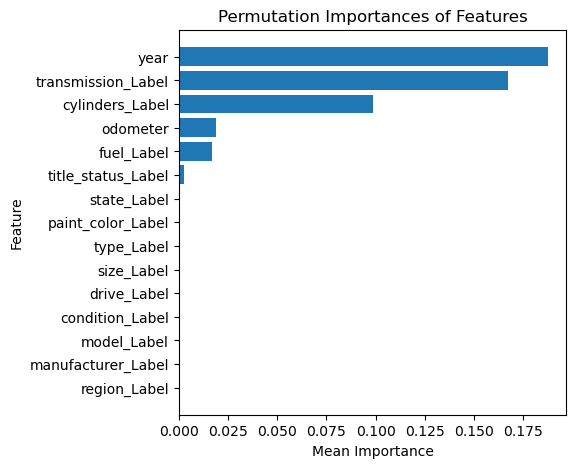

In [1576]:
# Sorting values for plotting
sorted_idx = np.argsort(r1.importances_mean)
sorted_feature_names = [feature_names_per_graph[i] for i in sorted_idx]
sorted_importances = r1.importances_mean[sorted_idx]

# Plotting
plt.figure(figsize=(5, 5))
plt.barh(sorted_feature_names, sorted_importances, align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances of Features')
plt.show()

Cars Details on the 3 features with positive coefs transmission, cylinders, condition level

In [1471]:
car_details.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 135257 to 424641
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        1350 non-null   object 
 1   price         1350 non-null   int64  
 2   year          1350 non-null   float64
 3   manufacturer  1350 non-null   object 
 4   model         1350 non-null   object 
 5   condition     1350 non-null   object 
 6   cylinders     1350 non-null   object 
 7   fuel          1350 non-null   object 
 8   odometer      1350 non-null   float64
 9   title_status  1350 non-null   object 
 10  transmission  1350 non-null   object 
 11  drive         1350 non-null   object 
 12  size          1350 non-null   object 
 13  type          1350 non-null   object 
 14  paint_color   1350 non-null   object 
 15  state         1350 non-null   object 
dtypes: float64(2), int64(1), object(13)
memory usage: 179.3+ KB


In [1485]:
X = car_details.drop(['price','region','year','manufacturer','model','odometer','title_status','size',
                       'type','paint_color','state'], axis = 1)
y = car_details['price']

In [1486]:
# Simple cross validation
X_train, X_test, y_train, y_test = '', '', '', ''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(type(X_test))
print(type(X_train))
X_train.shape, X_test.shape

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


((945, 5), (405, 5))

In [1487]:
#categorical_features = [['transmission', 'cylinders', 'condition', 'drive', 'fuel']]
preprocessor = make_column_transformer((OneHotEncoder(drop="if_binary"), ['transmission', 'cylinders', 'condition', 'drive', 'fuel'])
                                       , remainder="passthrough"
                                       , verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

In [1488]:
# Calling fit_trasform and transform to avoid memory issues with OneHotEncoder
# the result matrix is compressed sparse
model_2_train = preprocessor.fit_transform(X_train)
model_2_test = preprocessor.transform(X_test)
model_2_train

<945x25 sparse matrix of type '<class 'numpy.float64'>'
	with 4725 stored elements in Compressed Sparse Row format>

In [1489]:
# Now got the whole feature list including the results of OneHotEncoder
feature_name =preprocessor.get_feature_names_out().tolist()
feature_name

['transmission_automatic',
 'transmission_manual',
 'transmission_other',
 'cylinders_10 cylinders',
 'cylinders_12 cylinders',
 'cylinders_3 cylinders',
 'cylinders_4 cylinders',
 'cylinders_5 cylinders',
 'cylinders_6 cylinders',
 'cylinders_8 cylinders',
 'cylinders_other',
 'condition_excellent',
 'condition_fair',
 'condition_good',
 'condition_like new',
 'condition_new',
 'condition_salvage',
 'drive_4wd',
 'drive_fwd',
 'drive_rwd',
 'fuel_diesel',
 'fuel_electric',
 'fuel_gas',
 'fuel_hybrid',
 'fuel_other']

In [1490]:
# Decompressing the matrices calling toarray() 
# This gets the simple CV split
model_2_train_decompressed = model_2_train.toarray()
model_2_test_decompressed = model_2_test.toarray()
# Getting the train and test in dataframe to pass as fit parameters
X_t = pd.DataFrame(model_2_train_decompressed, columns = feature_name)
X_tst = pd.DataFrame(model_2_test_decompressed, columns = feature_name)
X_t

,transmission_automatic,transmission_manual,transmission_other,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,...,condition_new,condition_salvage,drive_4wd,drive_fwd,drive_rwd,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
941,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
942,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
943,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Calling Ridge model - Data transformed by OneHotEncoder**

Alpha parameters np.linspace(1, 100, 100)}

In [1491]:
# Create the pipeline for Ridge with StandardScaler
pipe = Pipeline([('scale', StandardScaler(with_mean=False)),
                 ('ridge', Ridge())])
# Alpha Ridge parameters - 100 numbers from 1 to 100
param_dict = {'ridge__alpha': np.linspace(1, 100, 100)}

In [1492]:
#Calling the Ridge model thru a GridSearchCV 
grid_2 = ''
model_2_train_mse = ''
model_2_test_mse = ''
model_2_best_alpha = ''
# Setting the GridSearchCV
grid_2 = GridSearchCV(pipe, param_grid=param_dict)
# Fitting the model
grid_2.fit(X_t, y_train)
train_preds = grid_2.predict(X_t)
test_preds = grid_2.predict(X_tst)
# Getting MSEs
model_2_train_mse = mean_squared_error(y_train, train_preds)
model_2_test_mse = mean_squared_error(y_test, test_preds)
# Best parameter
model_2_best_alpha = grid_2.best_params_

cv_results = grid_2.cv_results_
mean_test_scores = cv_results['mean_test_score']
best_model = grid_2.best_estimator_.named_steps['ridge']
# Getting the coefs and feature names
coefs = best_model.coef_
feature_names = X_t.columns

# Printing the MSEs 
print(f'Train MSE: {model_2_train_mse: .2f}')
print(f'Test MSE: {model_2_test_mse: .2f}')
# Print the best parameters and best score
print("Best Parameters:", grid_2.best_params_)
print("Best Score:", grid_2.best_score_)  
# Formating the coefs in a dataframe
coefs_df1 = pd.DataFrame(coefs.T, columns = ["Coefficients"], index = feature_names)
coefs_df1

Train MSE: 130344425.66612668
Test MSE: 143132306.89578187
Best Parameters: {'ridge__alpha': 100.0}
Best Cross-Validation MSE: -0.23202533043717902


,Coefficients
transmission_automatic,-1728.733519
transmission_manual,-1668.281398
transmission_other,2882.538702
cylinders_10 cylinders,241.843269
cylinders_12 cylinders,-145.302253
cylinders_3 cylinders,-284.481113
cylinders_4 cylinders,-737.556829
cylinders_5 cylinders,-164.808442
cylinders_6 cylinders,-137.078934
cylinders_8 cylinders,905.484618


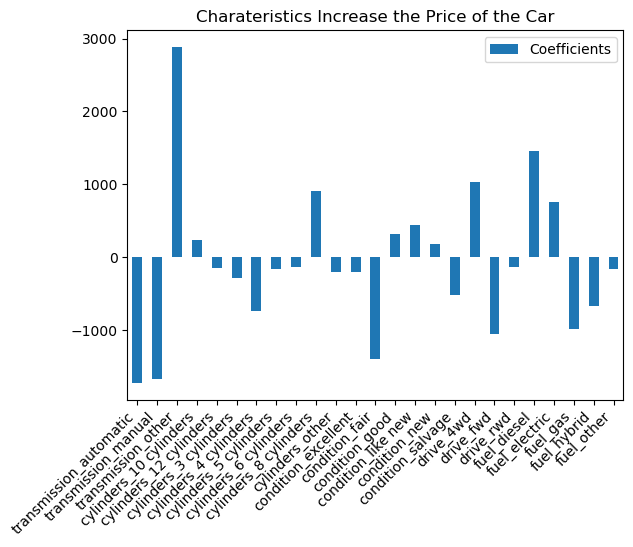

In [1589]:
coefs_df1.plot(kind = 'bar')
plt.title('Charateristics Increase the Price of the Car') 
plt.xticks(rotation=45, ha='right')
plt.show()

Plotiing in a different way 

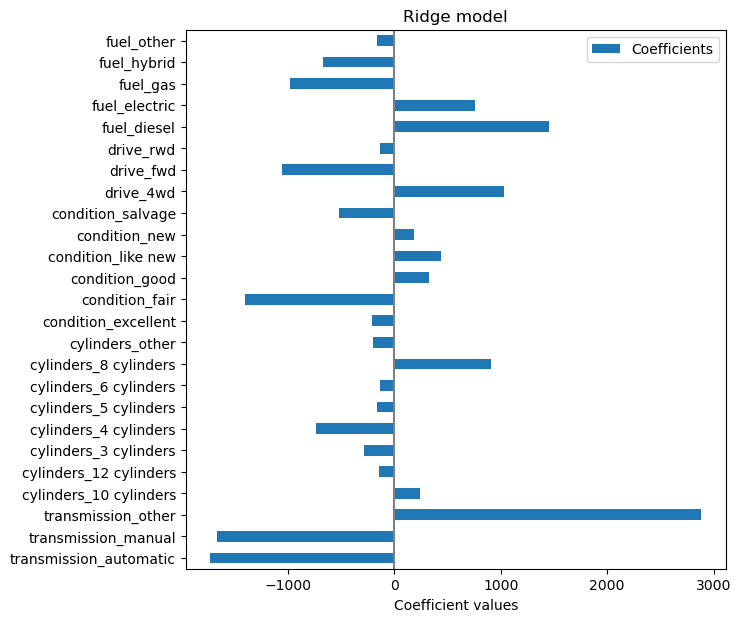

In [1593]:
coefs_df1.plot.barh(figsize=(9, 7))
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

**Running SequentialFeatureSelector with estimator as Lasso and Ridge as regression model**
Tried different paramters for the features - Settled on 6

In [1496]:
#Variables initialization
sequential_train_mse = ''
sequential_test_mse = ''
features = ''
sequential_pipe = ''
SFS_coefs_df = ''
#param_dict = {'selector__n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
# Create the pipeline
sequential_pipe = Pipeline([('selector', SequentialFeatureSelector(estimator = Lasso(), n_features_to_select=6)),
                            ('ridge', Ridge(96))])
# Fitting the model
sequential_pipe.fit(X_t, y_train)
# Getting the MSEs
sequential_train_mse = mean_squared_error(y_train, sequential_pipe.predict(X_t))
sequential_test_mse = mean_squared_error(y_test, sequential_pipe.predict(X_tst))
# Initializing variables
best_estimator = ''
best_selector = ''
best_model = ''
feature_names = ''
coefs = ''

# Getting the values for the best_selector
best_selector = sequential_pipe.named_steps['selector']
# Getting feature names
feature_names = X_t.columns[best_selector.get_support()]
features = best_selector.get_feature_names_out()
# Getting the coefs and score
coefs = sequential_pipe.named_steps['ridge'].coef_
score = sequential_pipe.named_steps['ridge'].score
# Printing MSEs
print(f'Train MSE: {sequential_train_mse: .2f}')
print(f'Test MSE: {sequential_test_mse: ,2f}')
print(f'Score: {score}')
# Formating the coefs
SFS_coefs_df = pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])
SFS_coefs_df

Train MSE: 144301109.85344082
Test MSE: 147296354.33438167
Score: <bound method RegressorMixin.score of Ridge(alpha=96)>
Coefs: [-2784.69527458  6543.64110972  1792.65799804 -1611.2373653
 -3609.52810113  3059.39367398]
Features:  Index(['transmission_automatic', 'transmission_other', 'cylinders_8 cylinders',
       'condition_fair', 'drive_fwd', 'fuel_diesel'],
      dtype='object')
Features2:  ['transmission_automatic' 'transmission_other' 'cylinders_8 cylinders'
 'condition_fair' 'drive_fwd' 'fuel_diesel']


,transmission_automatic,transmission_other,cylinders_8 cylinders,condition_fair,drive_fwd,fuel_diesel
model,-2784.695275,6543.64111,1792.657998,-1611.237365,-3609.528101,3059.393674


**Running RFE with estimator as Lasso and Ridge as regression model**
Tried different paramters for the features - Settled on 6

In [1497]:
# Getting the features with RFE
sequential_train_mse6 = ''
sequential_test_mse6 = ''
features = ''
sequential_pipe = ''
RFE_coefs_df = ''
#  Creating the pipeline
sequential_pipe = Pipeline([('selector', RFE(estimator = Lasso(), n_features_to_select=6)),
                          ('ridge', Ridge(96))])
# Fitting the model
sequential_pipe.fit(X_t, y_train)
sequential_train_mse6 = mean_squared_error(y_train, sequential_pipe.predict(X_t))
sequential_test_mse6 = mean_squared_error(y_test, sequential_pipe.predict(X_tst))
# Initializing variables
best_estimator = ''
best_selector = ''
best_model = ''
feature_names = ''
coefs = ''

# Get the best_selector
best_selector = sequential_pipe.named_steps['selector']
# Getting the feature names
feature_names = X_t.columns[best_selector.get_support()]
features = best_selector.get_feature_names_out()
# Getting coefs and score
coefs = sequential_pipe.named_steps['ridge'].coef_
score = sequential_pipe.named_steps['ridge'].score
# Printing MSEs
print(f'Train MSE: {sequential_train_mse6: .2f}')
print(f'Test MSE: {sequential_test_mse6: .2f}')
print(f'Score: {score}')
RFE_coefs_df = pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])
RFE_coefs_df

Train MSE: 150601541.55915624
Test MSE: 154467753.47365412
Score: <bound method RegressorMixin.score of Ridge(alpha=96)>
Coefs: [ 7918.90012244  -155.46553685 -1587.81534727  -155.45522757
  3585.45449725   928.77156529]
Features:  Index(['transmission_other', 'cylinders_3 cylinders', 'condition_fair',
       'condition_salvage', 'fuel_diesel', 'fuel_electric'],
      dtype='object')
Features2:  ['transmission_other' 'cylinders_3 cylinders' 'condition_fair'
 'condition_salvage' 'fuel_diesel' 'fuel_electric']


,transmission_other,cylinders_3 cylinders,condition_fair,condition_salvage,fuel_diesel,fuel_electric
model,7918.900122,-155.465537,-1587.815347,-155.455228,3585.454497,928.771565


Formatting results:

In [1569]:
results1 = pd.DataFrame({'Model' : ['Linear Regression FP', 'Ridge FP', 'SequentialFeatureSelector FP', 'RFE FP'],
                         'MSE Train' : [122648215.3, 122648215.3, 123435555.8, 140281596.8],
                         'MSE Test' : [123679777.2, 123679712.8, 124505552.2, 141176146.9]
                        })

In [1579]:
results2 = pd.DataFrame({'Model' : ['Ridge 2P', 'SequentialFeatureSelector 2P', 'RFE 2P'],
                         'MSE Train' : [130344425.7, 144301109.9, 150601541.6],
                         'MSE Test' : [143132306.9, 147296354.3, 154467753.5]
                        })

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

The goal of the project is to identify what car features increases the price of used cards. Because of this 
I worked with 3 model:
1. Ridge
2. SequentialFeatureSelector with Lasso
3. RFE with Lasso

Used 2 types of encoding:
1. LabelEncoder for the whole data set (after cleaning)
2. OneHotEncoder for key features

So I repeated the 3 model for each type of encoding. In the first pass I was able to get the most important features. In the second pass the models gave details of what are most prevalent in a great detail.

**First Pass**
Once the cardinal features were transformed, got the correlation matrix to show the relationship of the features and price.
As shown in the headmap graph the transmission, cylinders, and year are features with better correlation.

1. Used simple CV for all models
2. Used LinearRegression as base model
3. Created a pipeline with StandardScaler(with_mean=False) and Ridge() as regression model
4. Trying different numbers for the ridge alpha - settled for param_dict = {'ridge__alpha': np.linspace(1, 100, 100)}
5. Next model SequentialFeatureSelector with estimator = Lasso()
6. Last model RFE with estimator = Lasso()

In [1568]:
results1    

,Model,MSE Train,MSE Test
0,Linear Regression FP,122648215.3,123679777.2
1,Ridge FP,122648215.3,123679712.8
2,SequentialFeatureSelector FP,123435555.8,124505552.2
3,RFE FP,140281596.8,141176146.9


From the results above Ridge has the best MSE Test with the following coefficients:

In [1570]:
coefs_df

,Coefficients
year,3900.310559
odometer,-1273.362066
region_Label,-169.095935
manufacturer_Label,-319.487350
model_Label,134.643701
condition_Label,491.602881
cylinders_Label,2768.488272
fuel_Label,-1228.122920
title_status_Label,-500.903945
transmission_Label,3767.559215


Confirming with the coefs above, the permutation_importance showed results affirming the results from Ridge.
The graph below shows year, as expected, then transmission, cylinders, odometer (also expected), and fuel.

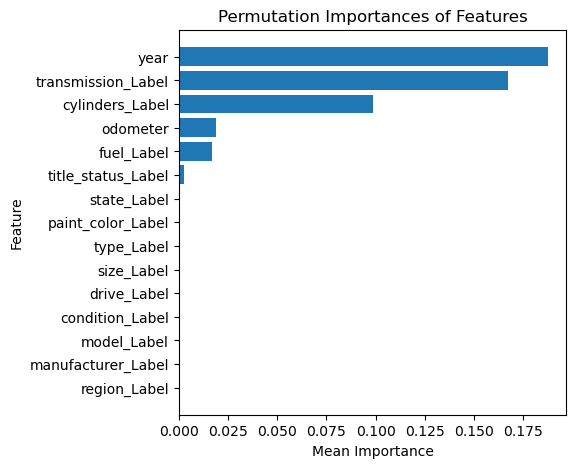

In [1577]:
# Sorting values for plotting
sorted_idx = np.argsort(r1.importances_mean)
sorted_feature_names = [feature_names_per_graph[i] for i in sorted_idx]
sorted_importances = r1.importances_mean[sorted_idx]

# Plotting
plt.figure(figsize=(5, 5))
plt.barh(sorted_feature_names, sorted_importances, align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances of Features')
plt.show()

**Second Pass**
Reduced the number of cardinal features to:  transmission, cylinders, condition, drive, fuel and transform the data using OneHotEncoder to get detailed information on the car features. 
**This time got a reduce dataset because of memory problems with the OneHotEncoder**

1. Calling fit_trasform and transform to avoid memory issues with OneHotEncoder
 the result matrix is compressed sparse
2. Decompressing the matrices calling toarray() . This gets the simple CV split
3. Calling Ridge model - Data transformed by OneHotEncoder using GridSearchCV
settled for param_dict = {'ridge__alpha': np.linspace(1, 100, 100)}
4. Running SequentialFeatureSelector with estimator as Lasso and Ridge as regression model**
Tried different parameters for the features - Settled on 6
5.  Running RFE with estimator as Lasso and Ridge as regression model**
Tried different parameters for the features - Settled on 6


In [1580]:
results2

,Model,MSE Train,MSE Test
0,Ridge 2P,130344425.7,143132306.9
1,SequentialFeatureSelector 2P,144301109.9,147296354.3
2,RFE 2P,150601541.6,154467753.5


From the results above Ridge has the best MSE Test with the following coefficients:

In [1581]:
coefs_df1

,Coefficients
transmission_automatic,-1728.733519
transmission_manual,-1668.281398
transmission_other,2882.538702
cylinders_10 cylinders,241.843269
cylinders_12 cylinders,-145.302253
cylinders_3 cylinders,-284.481113
cylinders_4 cylinders,-737.556829
cylinders_5 cylinders,-164.808442
cylinders_6 cylinders,-137.078934
cylinders_8 cylinders,905.484618


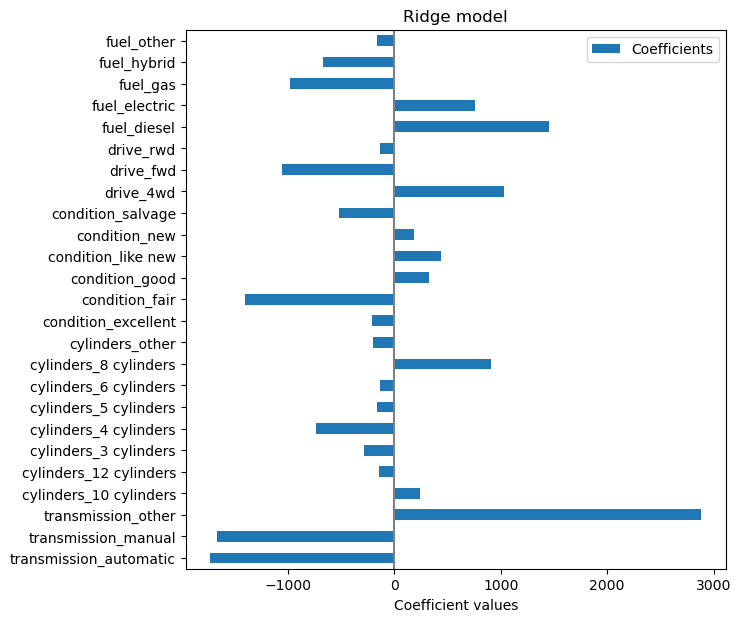

In [1584]:
coefs_df1.plot.barh(figsize=(9, 7))
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

From this grahp we can distiguish the more in detail features:
Price Increase:
- The coefs for transmission other has a high value affecting the car price in a positve way. In the same way we have 8 cylinders, diesel, electric, 4wd, condition like new, condition new and other with smaller coefs.
- In the other hand manual and automatic transmission, condition fair, condition salvage, drive fwd, gas, hybrid, cylinders 4,5,6,3 reduce the price of the used car

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

**Because the goal in not to predict prices, but analyze what are the car features that increase the value of the car I
prepare the following graphic on the main features:**

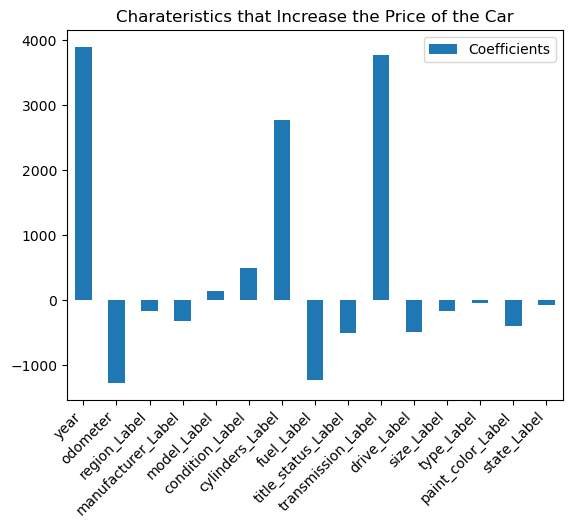

In [1594]:
coefs_df.plot(kind = 'bar')
plt.title('Charateristics that Increase the Price of the Car')  # Add a title (optional)
plt.xticks(rotation=45, ha='right')
plt.show()

From the graph above we can see year as as price factor, this one is expected as newer the car the higher the price 
could be.
- After that transmission is the one of the featues that customers value more
- Next is cylinders
- and the condition. This is a bit of surprise this come to be the 4 feature customers value on the use car
In the other hand there could be some features that could reduce more the car price:
- odometer is an expected one, the higher the number in the odometer the car loses value
- the next on the category is fuel, this is also expected as price values going to the roof

The following graph shows more in detail the car features for the follwoing categories: transmission, cylinders, condition, drive, fuel

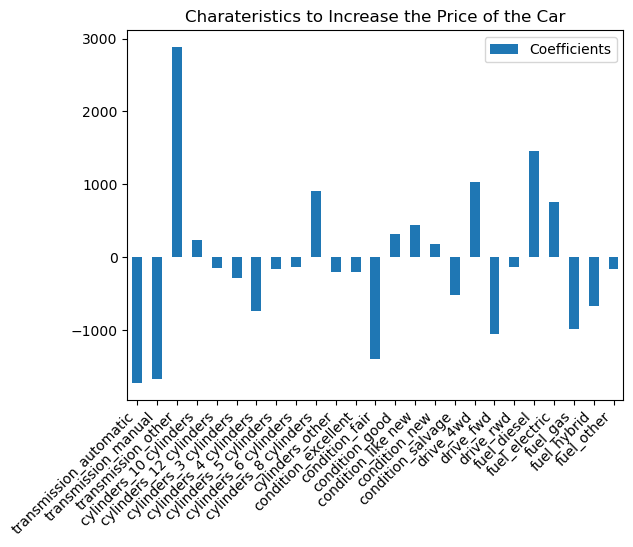

In [1595]:
coefs_df1.plot(kind = 'bar')
plt.title('Charateristics to Increase the Price of the Car')  # Add a title (optional)
plt.xticks(rotation=45, ha='right')
plt.show()

From this grahp we can distiguish the more in detail features:
Price Increase:
- Price increase for transmission other helps to increase the car price, this is because continuously variable transmission (CVT) and dual-clutch transmission (DCT) are more simpler and efficient that normal automatic or manual trainsmissions
- On the car cylinders 8 cylinders gives more value to the car
- Diesel is a preferable fuel. In general diesel is more efficient.
- Next electric cars
- In terms of drive the 4wd gives helps to increase the car price
- Finally, condition "like new" or "good" are preferable on car value